<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/linreg/linreg_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear models

In this notebook, we illustrate how to fit conditional ("discriminative") prediction models of the form $p(y|x,\theta)=p(y|f(x,\theta))$, where $y$ can be continuous ("regression"), or categorical ("classifcation"), or a count variable ("generalized linear model"). We assume $f(x,\theta)$ is linear in $\theta$.


In [1]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# We install various packages for approximate Bayesian inference
# To avoid installing packages the internet every time you open a colab,
# you can use this trick:
# https://stackoverflow.com/questions/55253498/how-do-i-install-a-library-permanently-in-colab

# The PyMC3 package (https://docs.pymc.io) supports HMC and variational inference
# https://docs.pymc.io/notebooks/api_quickstart.html
!pip install pymc3==3.8
import pymc3 as pm
pm.__version__

# The arviz package (https://github.com/arviz-devs/arviz) can be used to make various plots
# of posterior samples generated by any algorithm. 
!pip install arviz
import arviz as az

     |████████████████████████████████| 911kB 9.3MB/s 
     |████████████████████████████████| 1.5MB 32.2MB/s 
     |████████████████████████████████| 4.1MB 32.2MB/s 
     |████████████████████████████████| 327kB 46.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


# Linear regression (MLE)

We discuss maximum likelihood estimation for linear regression models of the form

$p(y|x,\theta)=N(y|\theta^T [1,x], \sigma^2) = N(y|w_0 + w_1^T x, \sigma^2)$


In [0]:
# https://github.com/probml/pyprobml/blob/master/scripts/linreg_poly_vs_degree.py

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler 
import sklearn.metrics 
from sklearn.metrics import mean_squared_error as mse

In [0]:
def make_1dregression_data(n=21):
    np.random.seed(0)
    xtrain = np.linspace(0.0, 20, n)
    xtest = np.arange(0.0, 20, 0.1)
    sigma2 = 4
    w = np.array([-1.5, 1/9.])
    fun = lambda x: w[0]*x + w[1]*np.square(x)
    ytrain = fun(xtrain) + np.random.normal(0, 1, xtrain.shape) * \
        np.sqrt(sigma2)
    ytest= fun(xtest) + np.random.normal(0, 1, xtest.shape) * \
        np.sqrt(sigma2)
    return xtrain, ytrain, xtest, ytest

xtrain, ytrain, xtest, ytest = make_1dregression_data(n=21)

#Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))


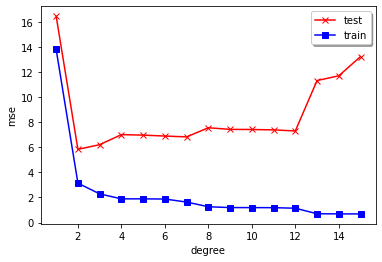

In [5]:
degs = np.arange(1, 21, 1)
ndegs = np.max(degs)
mse_train = np.empty(ndegs)
mse_test = np.empty(ndegs)
ytest_pred_stored = np.empty(ndegs, dtype=np.ndarray)
ytrain_pred_stored = np.empty(ndegs, dtype=np.ndarray)
for deg in degs:
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain) 
    ytrain_pred = model.predict(Xtrain_poly)
    ytrain_pred_stored[deg-1] = ytrain_pred
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[deg-1] = mse(ytrain_pred, ytrain) 
    mse_test[deg-1] = mse(ytest_pred, ytest)
    ytest_pred_stored[deg-1] = ytest_pred
    
# Plot MSE vs degree
fig, ax = plt.subplots()
mask = degs <= 15
ax.plot(degs[mask], mse_test[mask], color = 'r', marker = 'x',label='test')
ax.plot(degs[mask], mse_train[mask], color='b', marker = 's', label='train')
ax.legend(loc='upper right', shadow=True)
plt.xlabel('degree')
plt.ylabel('mse')
#save_fig('polyfitVsDegree.pdf')
plt.show()

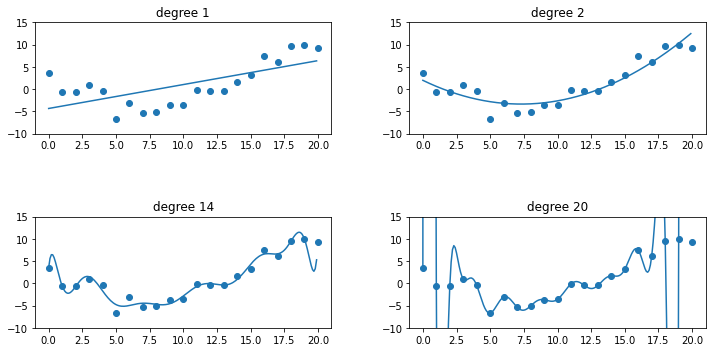

In [15]:
# Plot fitted functions
chosen_degs = [1, 2, 14, 20]
fig, axs = plt.subplots(2,2, figsize=(10,5))
axs = axs.reshape(-1)
for i, deg in enumerate(chosen_degs):
    axs[i].scatter(xtrain, ytrain)
    axs[i].plot(xtest, ytest_pred_stored[deg-1])
    axs[i].set_ylim((-10, 15))
    axs[i].set_title('degree {}'.format(deg))
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()
    

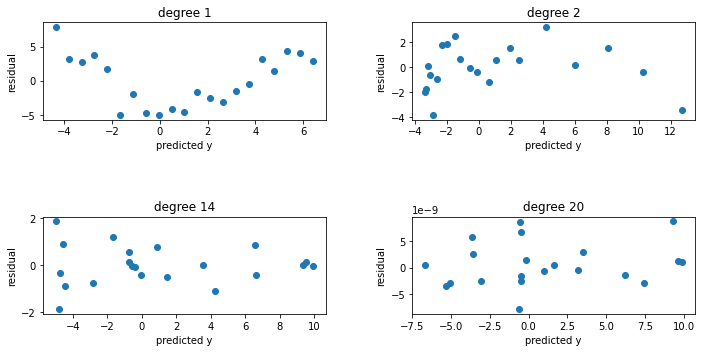

In [18]:
# Plot residuals
#https://blog.minitab.com/blog/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis
chosen_degs = [1, 2, 14, 20]
fig, axs = plt.subplots(2,2, figsize=(10,5))
axs = axs.reshape(-1)
for i, deg in enumerate(chosen_degs):
    ypred =  ytrain_pred_stored[deg-1]
    residuals = ytrain - ypred
    axs[i].plot(ypred, residuals, 'o')
    axs[i].set_xlabel('predicted y')
    axs[i].set_ylabel('residual')
    axs[i].set_title('degree {}'.format(deg))
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()


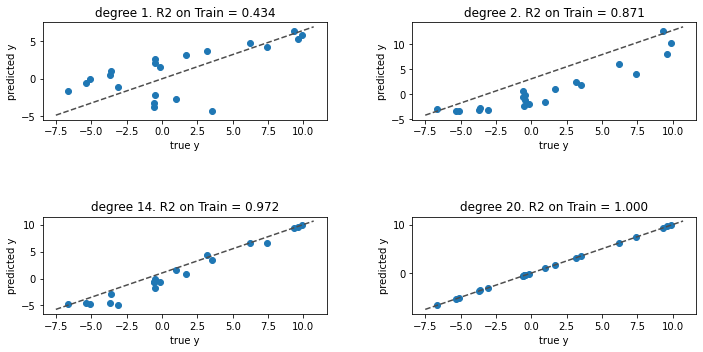

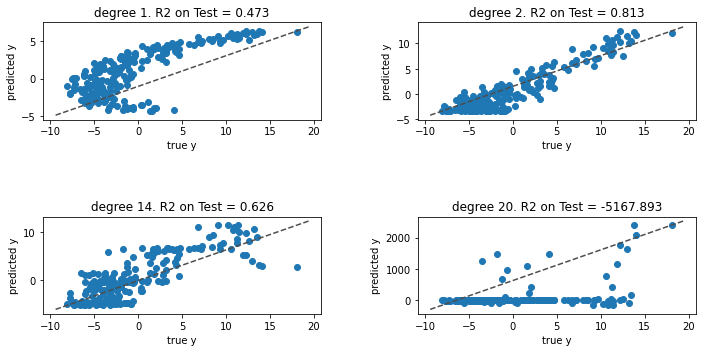

In [20]:
chosen_degs = [1, 2, 14, 20]
for train in [True, False]:
  fig, axs = plt.subplots(2,2, figsize=(10,5))
  axs = axs.reshape(-1)
  for i, deg in enumerate(chosen_degs):
        if train:
            ytrue = ytrain
            ypred = ytrain_pred_stored[deg-1]
            dataset = 'Train'
        else:
            ytrue = ytest
            ypred = ytest_pred_stored[deg-1]
            dataset = 'Test'
        axs[i].scatter(ytrue, ypred)
        # Plot diagonal line
        axs[i].plot(axs[i].get_xlim(), axs[i].get_ylim(), ls="--", c=".3")
        axs[i].set_xlabel('true y')
        axs[i].set_ylabel('predicted y')
        r2 = sklearn.metrics.r2_score(ytrue, ypred)
        axs[i].set_title('degree {}. R2 on {} = {:0.3f}'.format(deg, dataset, r2))
  fig.tight_layout(h_pad=5, w_pad=5)
  plt.show()


# Bayesian linear regression

We borrow some code examples from chapter 3 of [Bayesian Analysis with Python (2nd end)](https://github.com/aloctavodia/BAP) by Osvaldo Martin.

In [0]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
noiseSD = 0.5
eps_real = np.random.normal(0, noiseSD, size=N)

x = np.random.normal(10, 1, N) # centered on 10
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# save untransformed data for later
x_orig = x
y_orig = y



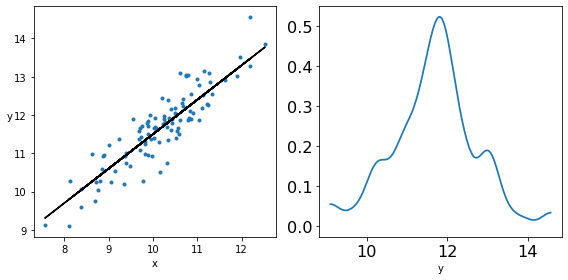

In [36]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()


## Compute posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1172.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f694f49aac8>,
      dtype=object)

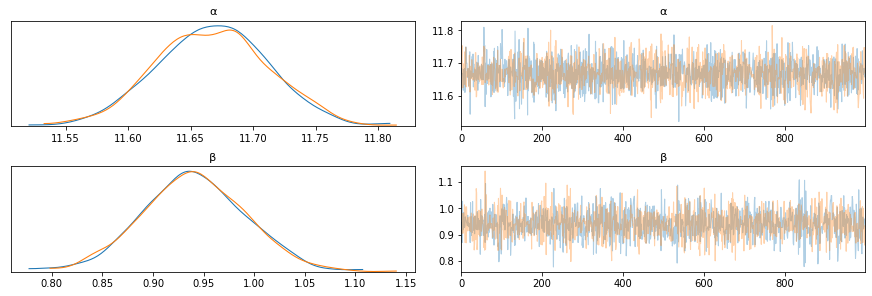

In [42]:
# Fit posterior with MCMC instead of analytically (for simplicity and flexibility)
# This is the same as BAP code, except we fix the noise variance to a constant.

with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    #y_pred = pm.Normal('y_pred', mu=μ, sd=noiseSD, observed=y)
    trace_g = pm.sample(1000)

az.plot_trace(trace_g, var_names=['α', 'β'])

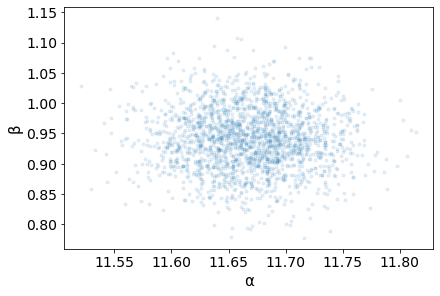

In [43]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1});

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 966.38it/s]
The acceptance probability does not match the target. It is 0.8824030686813656, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9060882438380661, but should be close to 0.8. Try to increase the number of tuning steps.


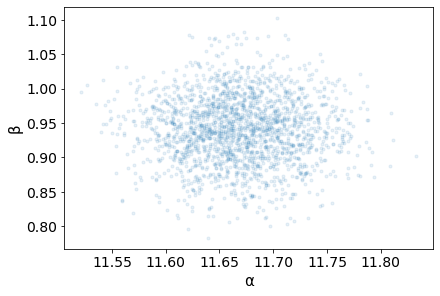

In [44]:
# To reduce the correlation between alpha and beta, we can center the data
x_centered = x_orig - x_orig.mean()

# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

with pm.Model() as model_g_centered:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_centered)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_g_centered = pm.sample(1000)


az.plot_pair(trace_g_centered, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1});

## Compute posterior predictive

2000


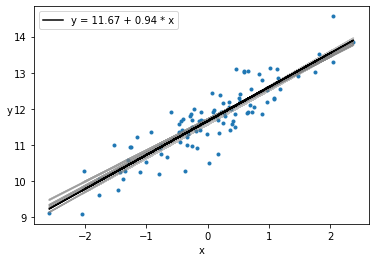

In [51]:
# Samples from posterior predictive

plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

np.random.seed(0)
nsamples = len(trace_g['α'])
print(nsamples)
draws = range(0, nsamples, 200)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()


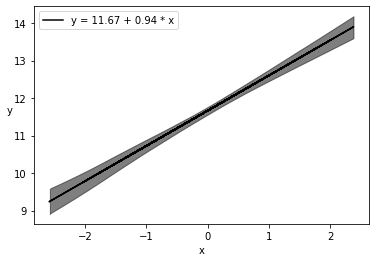

In [52]:
# HPD for posterior predictive

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()


100%|██████████| 2000/2000 [00:03<00:00, 574.81it/s]


Text(0, 0.5, 'y')

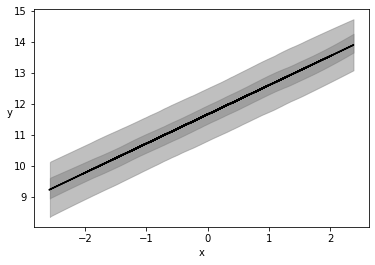

In [53]:
# arviz has nicer plotting

ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray') # central 50% HPD
az.plot_hpd(x, ppc['y_pred'], color='gray') # 94% HPD

plt.xlabel('x')
plt.ylabel('y', rotation=0)